In [1]:
!python generate_data.py

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from functools import reduce
from utils.models import strong_model_factory, weak_model_factory
from utils.tools import load_obj, summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext blackcellmagic


%load_ext autoreload
%autoreload 2

# Strong Priors

In [3]:
model_data = load_obj('data/bootstrap_data')

yobs = model_data['Yobs']
subject_ids = model_data['subject_ids']
y = model_data['y_est']
times = model_data['times']

with strong_model_factory(yobs, times, subject_ids, use_delay = True):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    strong_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
100%|██████████| 4000/4000 [00:06<00:00, 649.96it/s]


In [4]:
df = pd.DataFrame({'yobs':yobs,
                   'y':y,
                   'times':times,
                   'subject_ids':subject_ids})

predictions = summarize_posterior(strong_data, 'y_est', 'pred')
ppc = summarize_ppc(strong_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

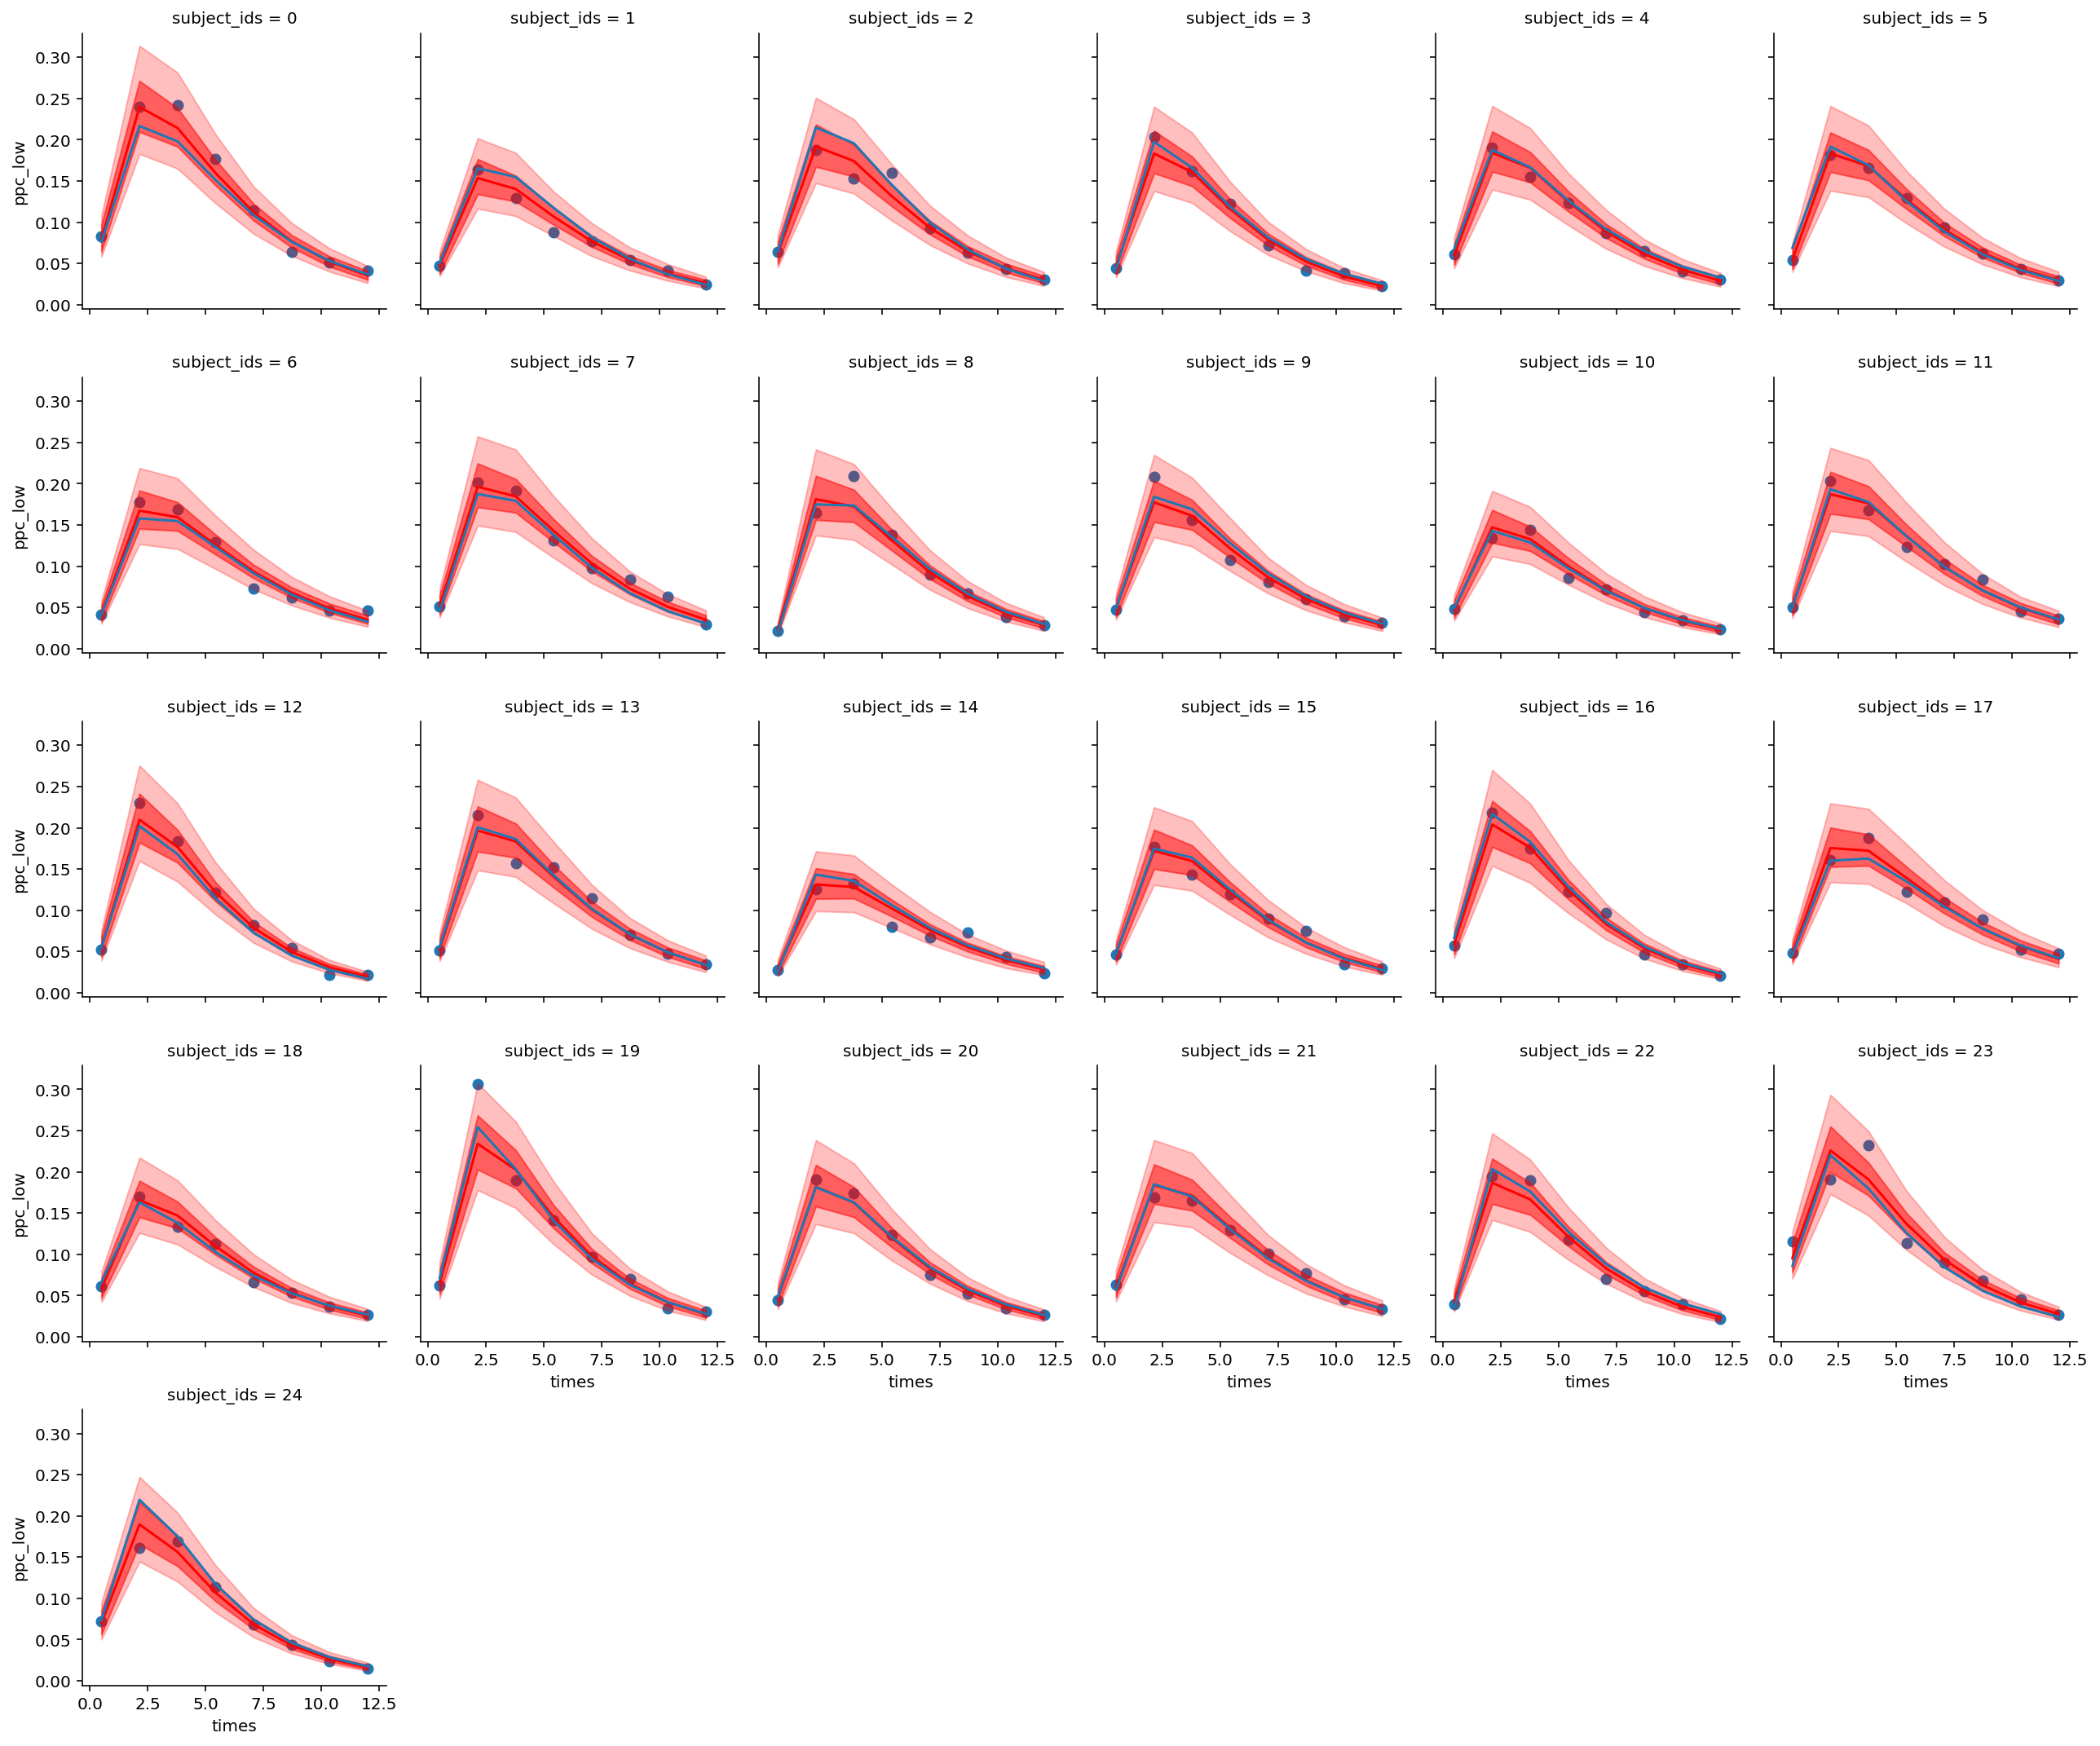

In [5]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'red')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'red')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'red')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2fae4ad0>],
      dtype=object)

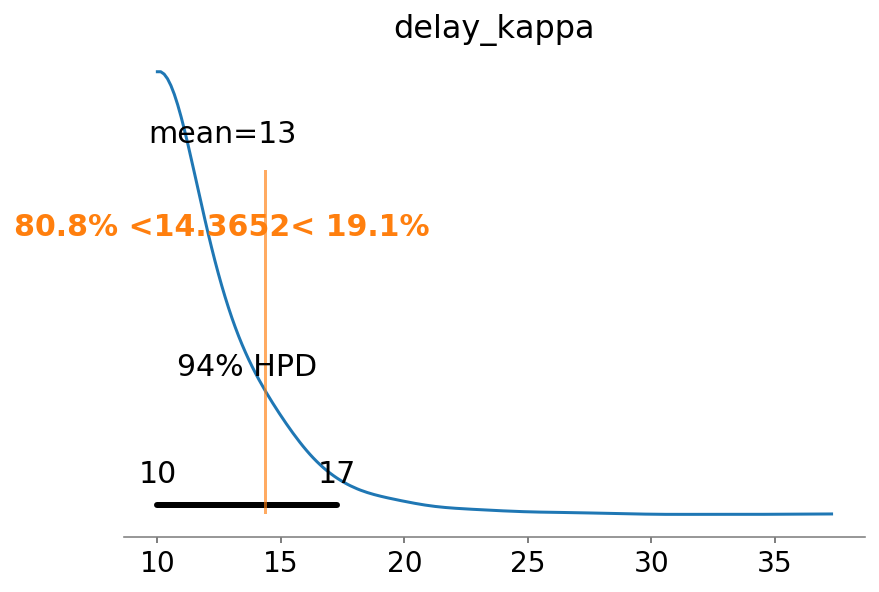

In [9]:
az.plot_posterior(strong_data, var_names=['delay_kappa'], ref_val=float(model_data['delay_kappa']))

# Weak Priors

In [10]:
with weak_model_factory(yobs, times, subject_ids, use_delay = True):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    weak_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)
    
predictions = summarize_posterior(weak_data, 'y_est', 'pred')
ppc = summarize_ppc(weak_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 4 chains, 115 divergences: 100%|██████████| 8000/8000 [00:51<00:00, 155.81draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5663857496924161, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.623943978840426, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is sma

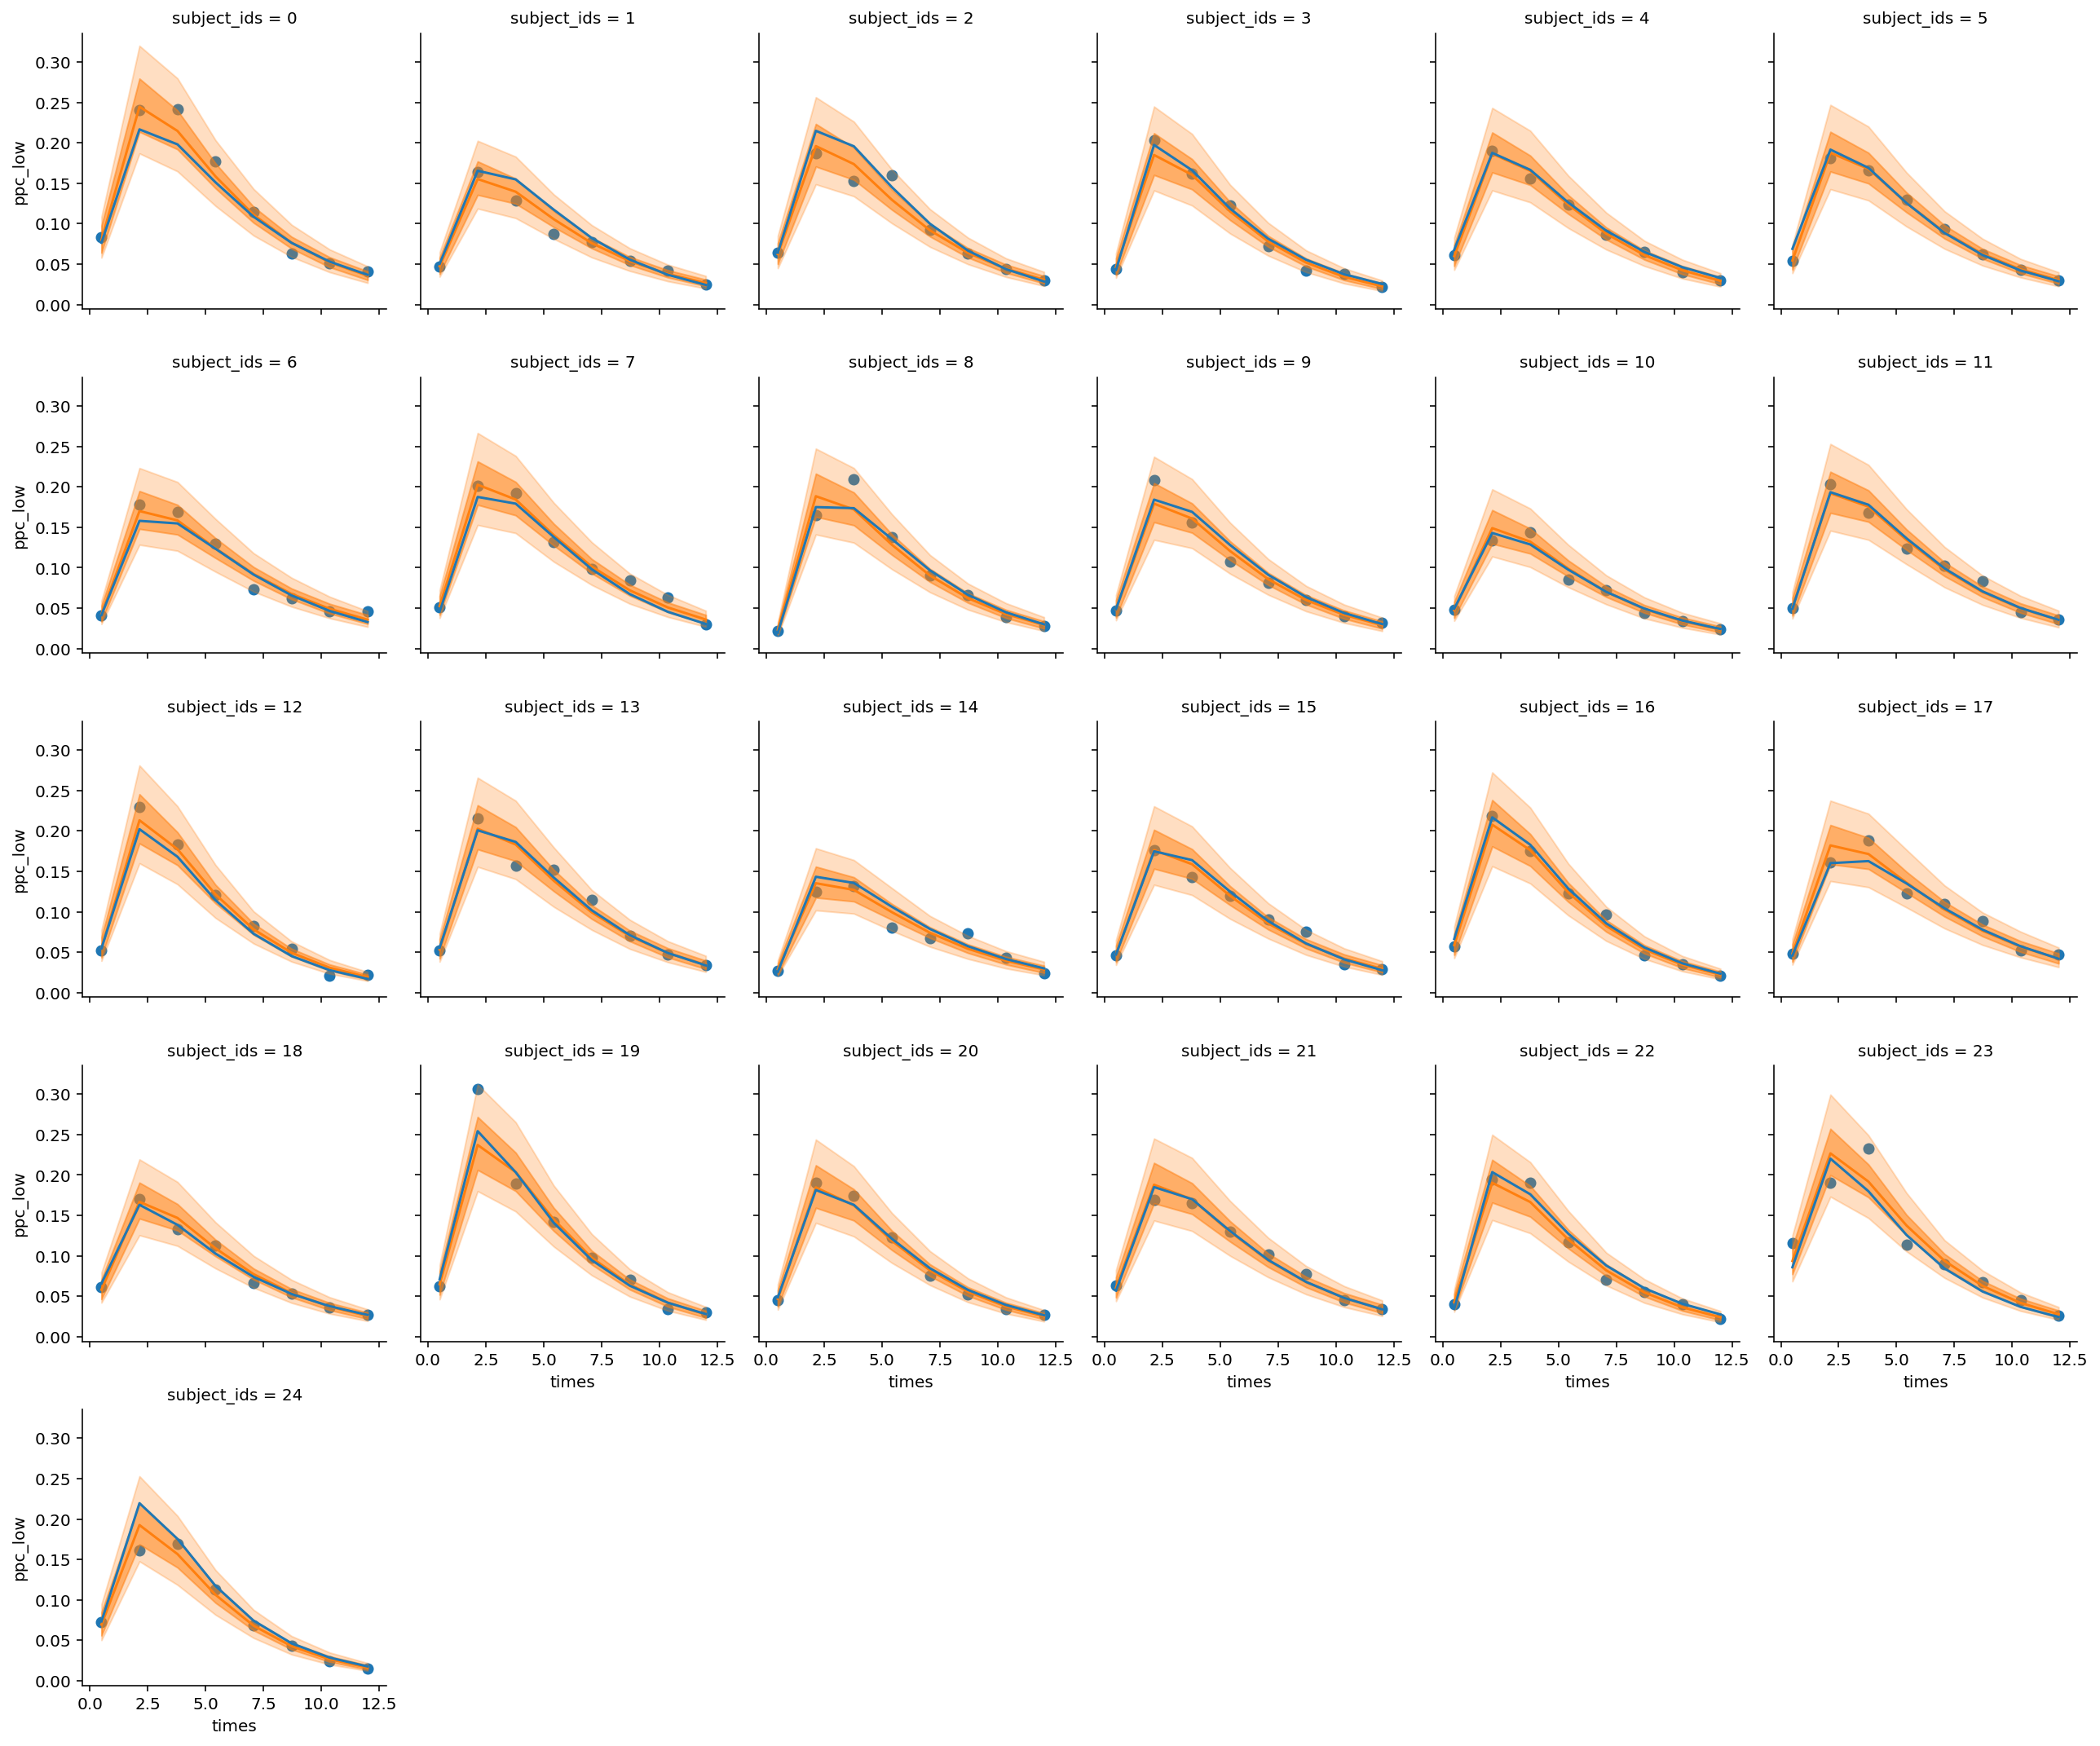

In [24]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C1')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

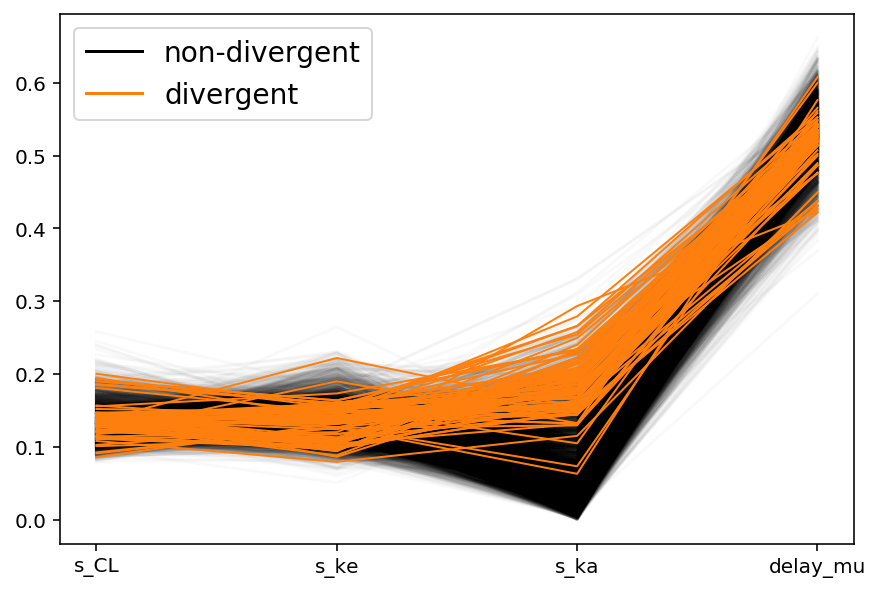

In [14]:
az.plot_parallel(weak_data, var_names=['s_CL','s_ke','s_ka', 'delay_mu'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4b5bef10>,
      dtype=object)

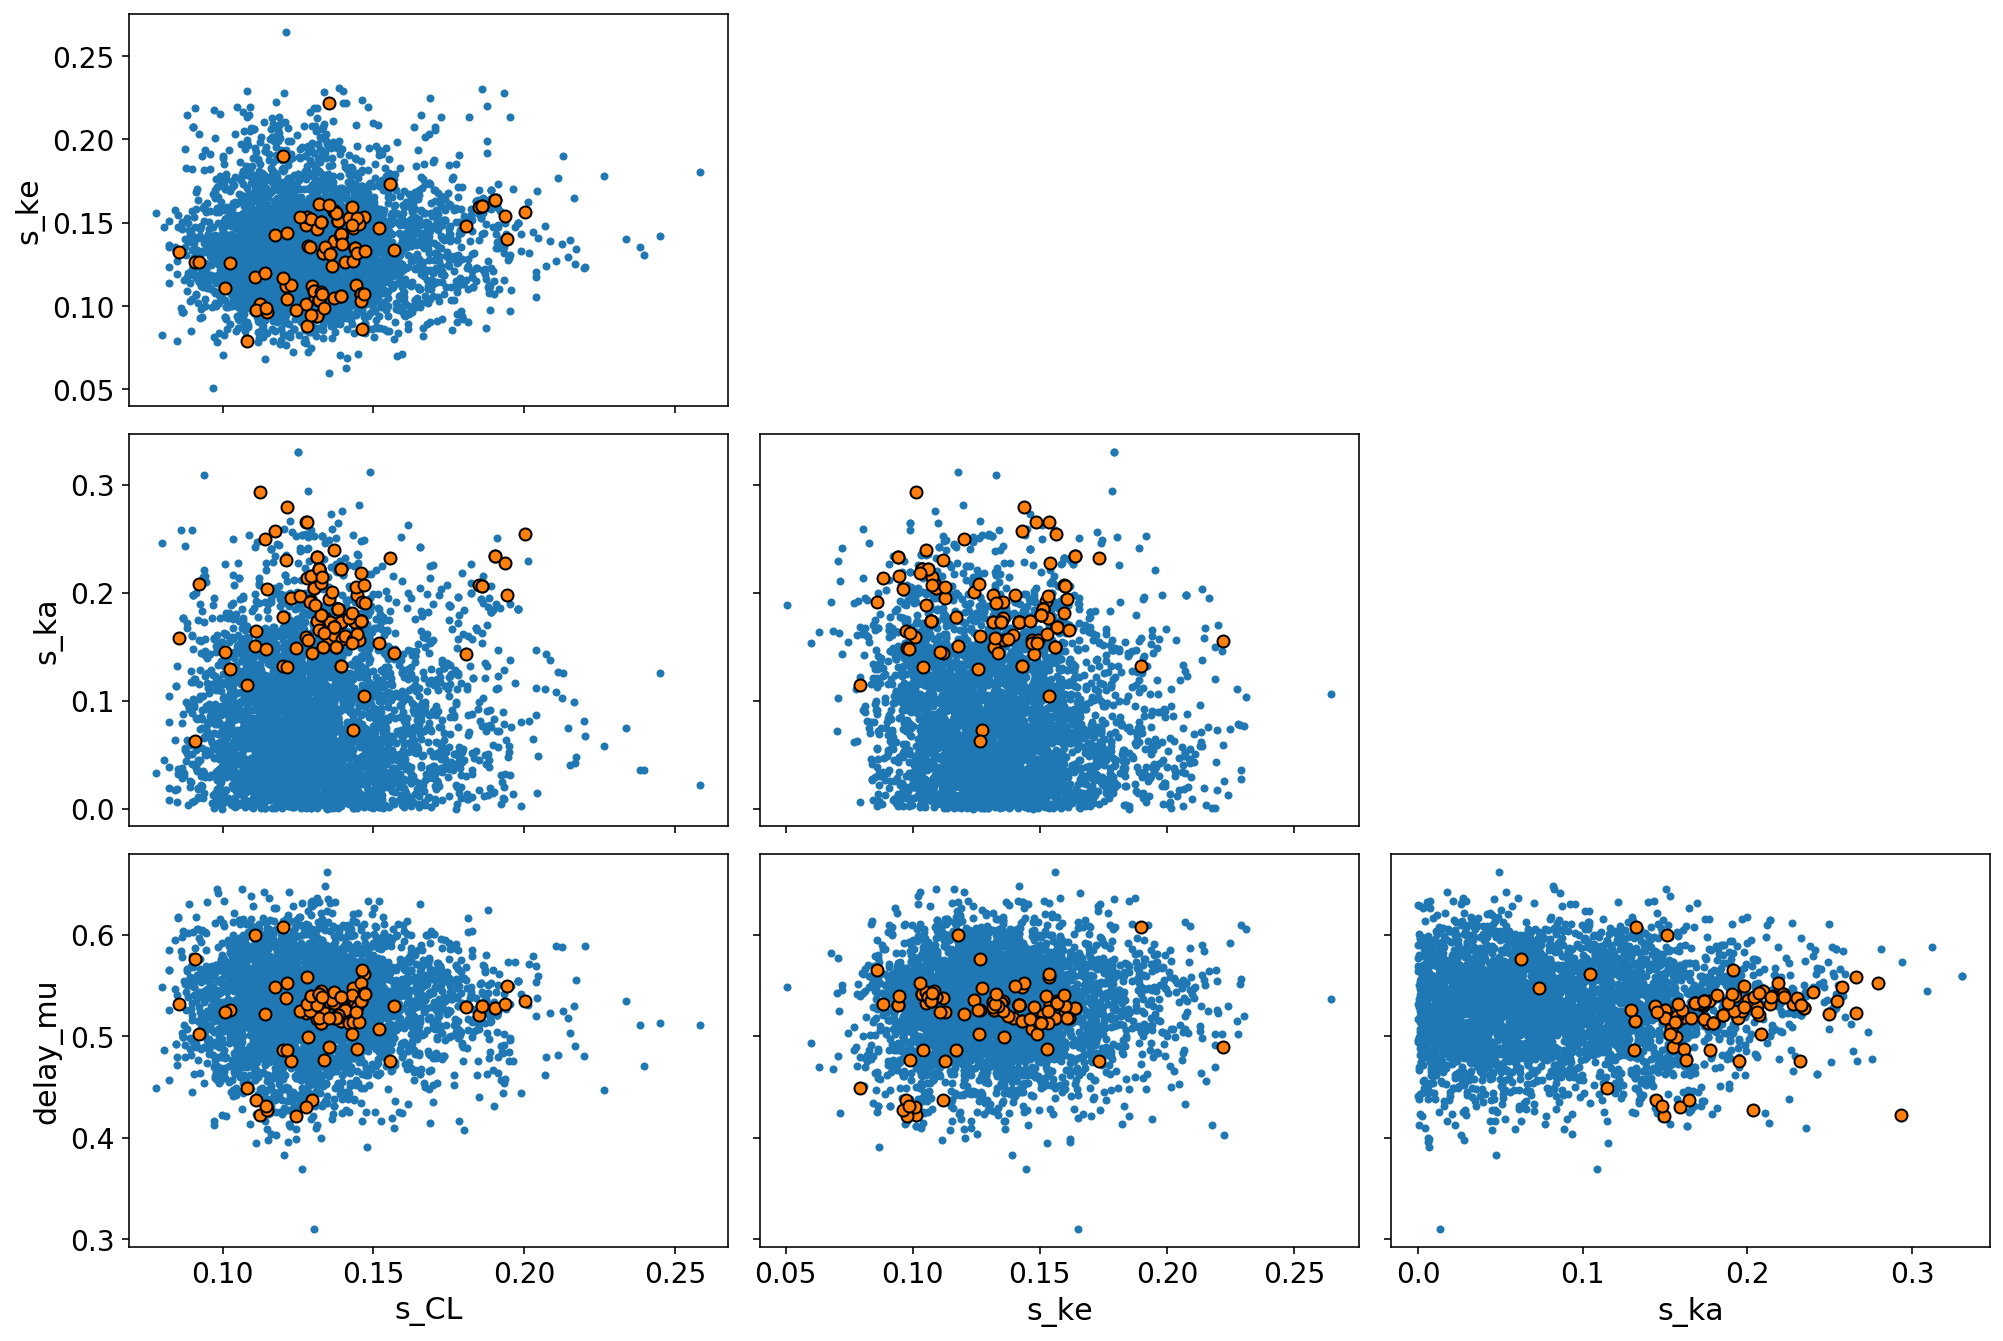

In [26]:
az.plot_pair(weak_data, var_names=['s_CL','s_ke','s_ka', 'delay_mu'], divergences = True)

# No random effect in $k_a$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:42<00:00, 186.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:05<00:00, 715.98it/s]


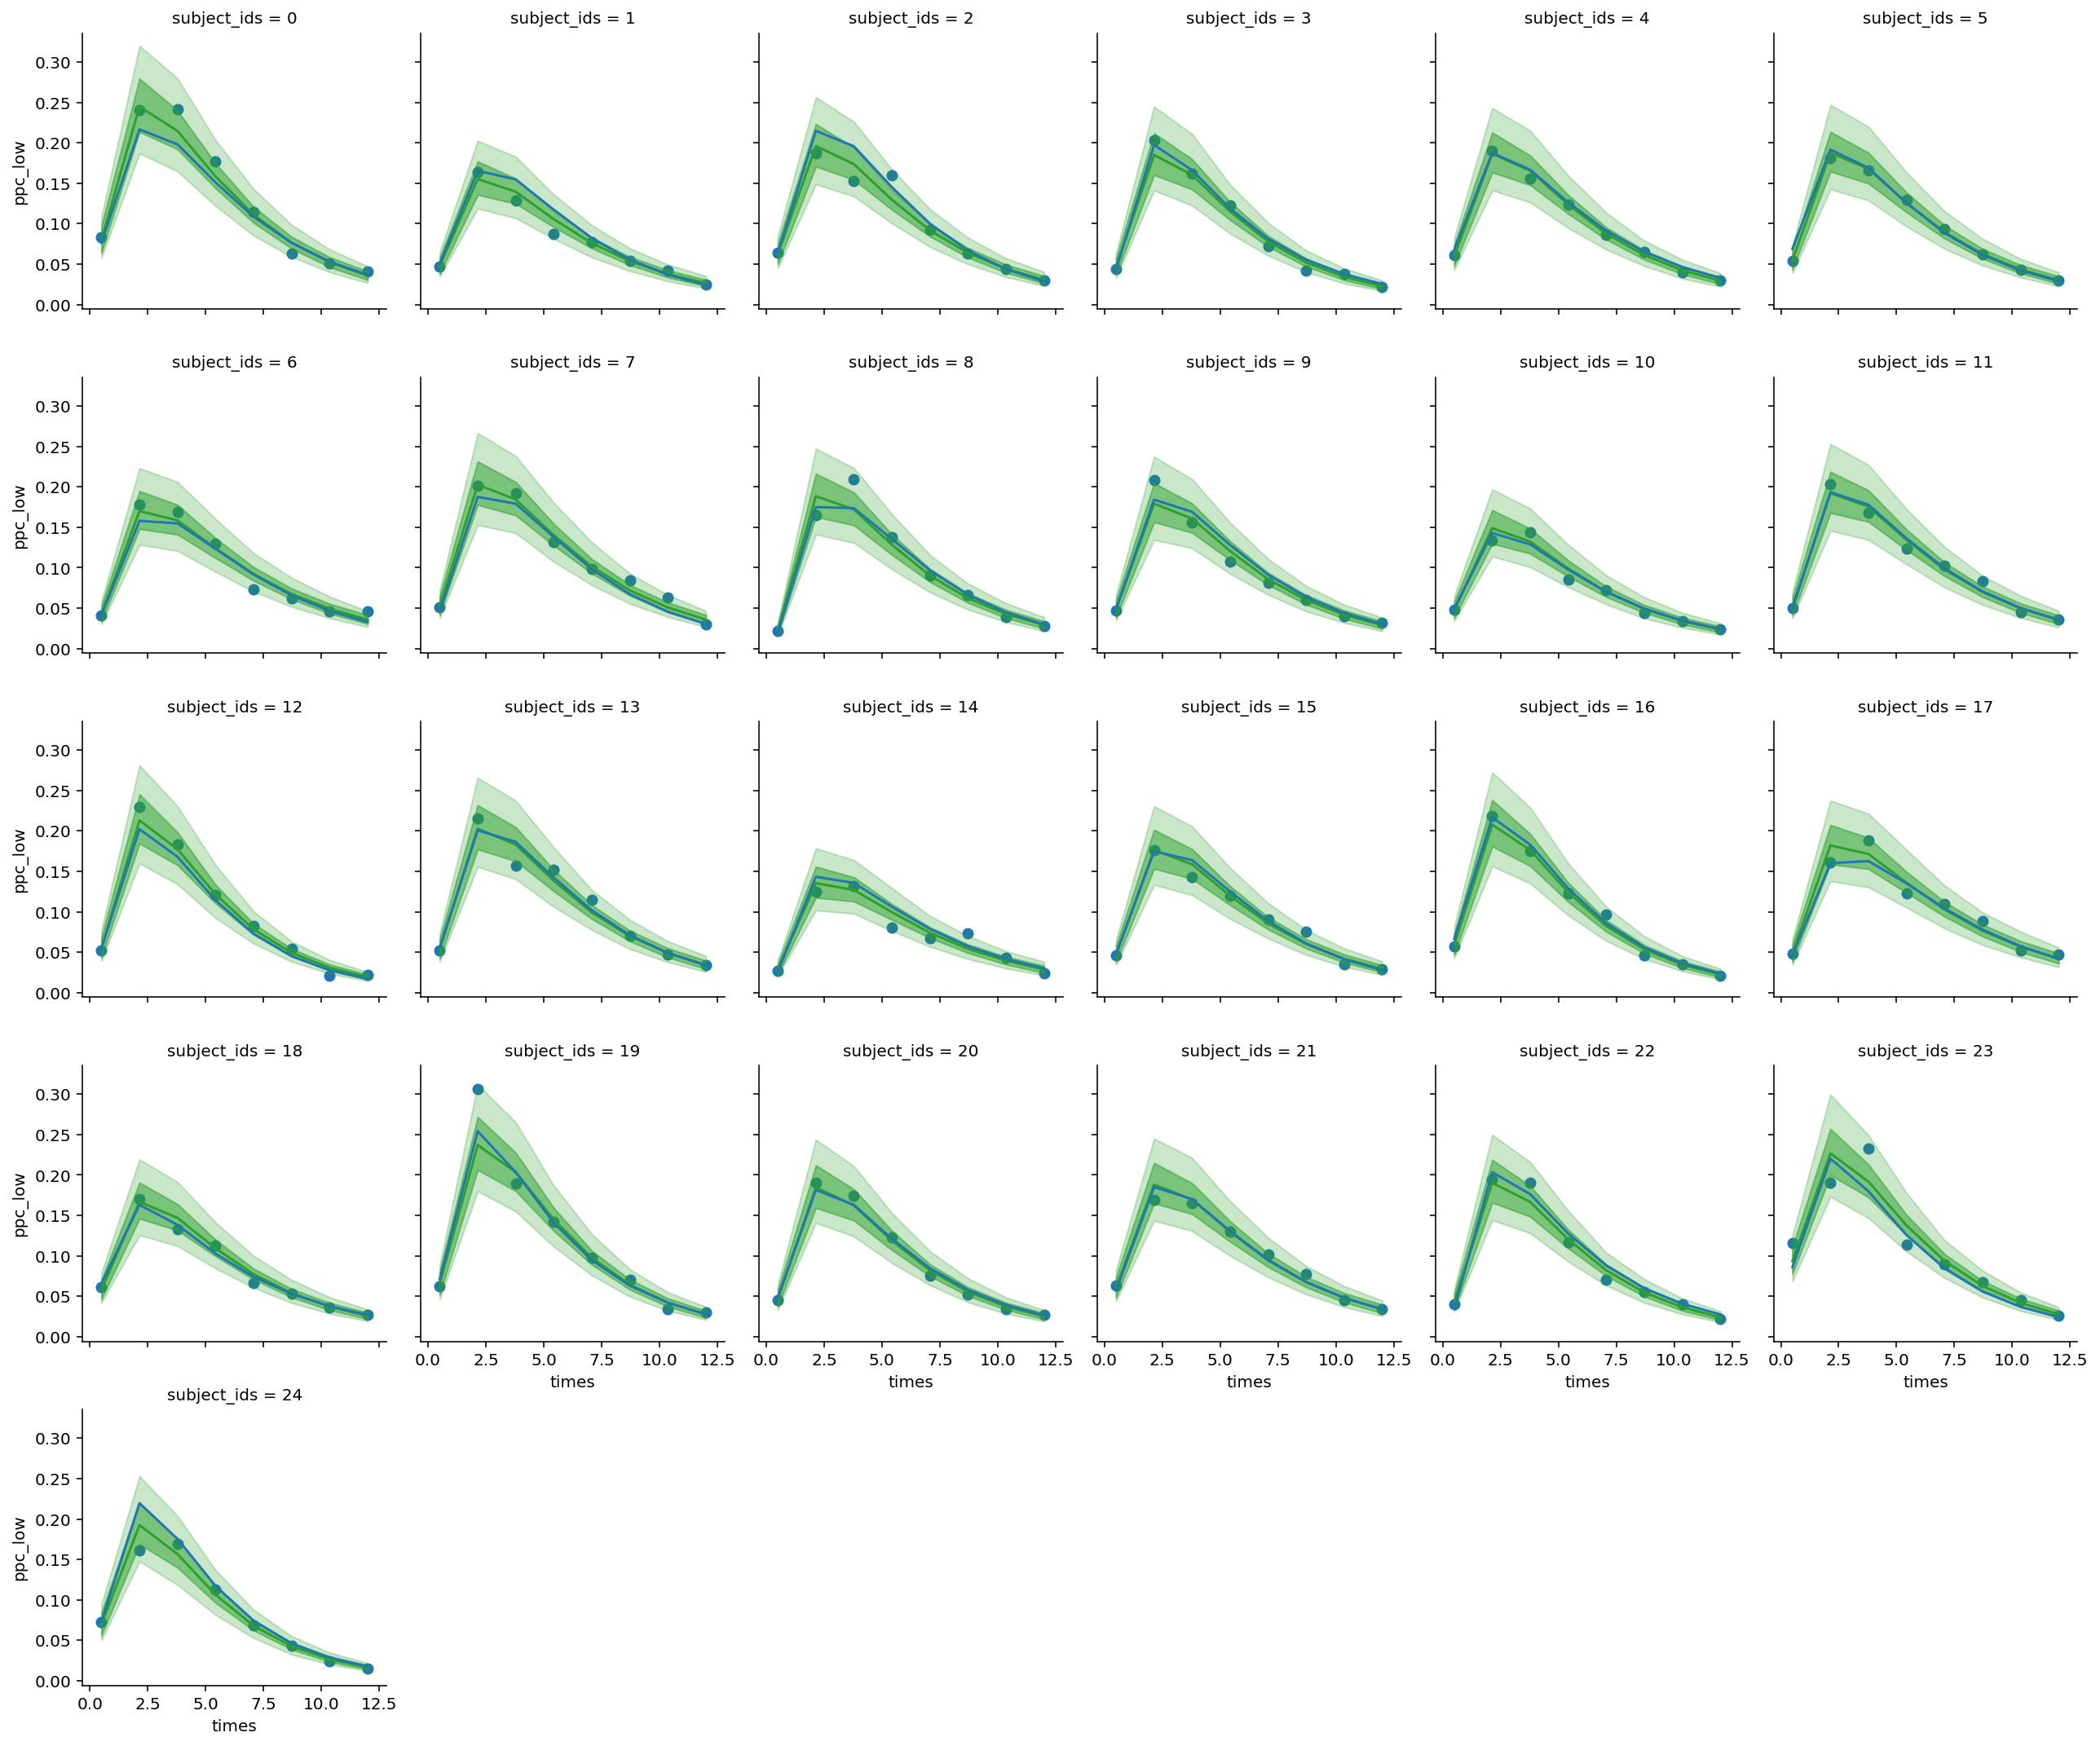

In [18]:
import theano.tensor as tt


def no_rfx_model_factory(Yobs, times, subject_ids, use_delay = True):
    """Returns a model context for a weakly informative model.

    Inputs:
    Yobs -- array of observed concentrations at indicated times
    times -- array of observation tiems
    subject_ids -- array of integers used as subject identifiers

    Returns:
    pk_model -- Model context.

    """

    # This is the case when I am simulating from the prior predictive.
    if Yobs is None:
        Yobs = np.zeros_like(times)

    with pm.Model() as pk_model:

        log_CL = pm.Bound(pm.Normal, lower=0)("log_CL", tt.log(3.5), 1)
        z_CL = pm.Normal("z_CL", 0, 1, shape=len(np.unique(subject_ids)))
        s_CL = pm.HalfCauchy("s_CL", 1)

        log_ke = pm.Normal("log_ke", -1.5, 1)
        z_ke = pm.Normal("z_ke", 0, 1, shape=len(np.unique(subject_ids)))
        s_ke = pm.HalfCauchy("s_ke", 1)

        alpha = pm.Beta("alpha", 1, 1)
        log_ka = pm.Deterministic("log_ka", log_ke - tt.log(alpha))

        CL = pm.Deterministic("Cl", tt.exp(log_CL + z_CL[np.unique(subject_ids)] * s_CL))
        ke = pm.Deterministic("ke", tt.exp(log_ke + z_ke[np.unique(subject_ids)] * s_ke))
        ka = pm.Deterministic("ka", tt.exp(log_ka) ) 
        
        if use_delay:

            delay_mu = pm.Beta('delay_mu',1,1)
            delay_kappa = pm.HalfCauchy('delay_kappa', 1)
            delay_alpha = pm.Deterministic('delay_alpha', delay_mu*delay_kappa)
            delay_beta = pm.Deterministic('delay_beta', (1-delay_mu)*delay_kappa)

            delays = pm.Beta('delays', delay_alpha, delay_beta, shape = len(np.unique(subject_ids)))

            delayed_times = times - 0.5*delays[subject_ids]

            y_est = (
                5
                / CL[subject_ids]
                * (ke[subject_ids] * ka)
                / (ke[subject_ids] - ka)
                * (tt.exp(-ka * delayed_times) - tt.exp(-ke[subject_ids] * delayed_times))
            )

        else:
                
            y_est = (
                5
                / CL[subject_ids]
                * (ke[subject_ids] * ka)
                / (ke[subject_ids] - ka)
                * (tt.exp(-ka * times) - tt.exp(-ke[subject_ids] * times))
            )

        y_conc = pm.Deterministic("y_est", y_est)
        sigma = pm.HalfCauchy("sigma", 1)

        y = pm.Lognormal("Yobs", tt.log(y_est), sigma, observed=Yobs)

    return pk_model


with no_rfx_model_factory(yobs, times, subject_ids, use_delay = True):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    rfx_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)
    
predictions = summarize_posterior(rfx_data, 'y_est', 'pred')
ppc = summarize_ppc(rfx_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C2')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C2')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C2')

# Summarize Posteriors With Mean and Credible Interval

In [19]:
funcs = {'mean':np.mean, 'hpd_2.5%':lambda x: np.percentile(x, 2.5), 'hpd_97.5%':lambda x: np.percentile(x, 97.5)}
num_funcs = len(funcs.keys())

strong_summary = az.summary(strong_data, stat_funcs=funcs, extend = False)
strong_summary['model'] = 'strong'


weak_summary = az.summary(weak_data, stat_funcs=funcs, extend = False)
weak_summary['model'] = 'weak'

rfx_summary = az.summary(rfx_data, stat_funcs=funcs, extend = False)
rfx_summary['model'] = 'no_rfx'


model_summaries = pd.concat((strong_summary, weak_summary, rfx_summary))





In [20]:
model_summaries


,mean,hpd_2.5%,hpd_97.5%,model
log_CL,1.315,1.266,1.364,strong
z_CL[0],-2.009,-2.813,-1.195,strong
z_CL[1],1.262,0.487,2.052,strong
z_CL[2],-0.371,-1.162,0.386,strong
z_CL[3],0.805,0.008,1.603,strong
...,...,...,...,...
y_est[196],0.068,0.062,0.074,no_rfx
y_est[197],0.043,0.039,0.047,no_rfx
y_est[198],0.026,0.023,0.030,no_rfx
y_est[199],0.016,0.014,0.019,no_rfx


In [21]:
variables={}
for var in model_data:
    
    if model_data[var].size>1:
        data= model_data[var]
        for i in range(data.size):
            variables[f'{var}[{i}]'] = data[i]
    else:
        variables[var] = float(model_data[var])
    

In [22]:
g = pd.DataFrame(variables.values(), columns=['mean'], index = variables.keys())
g['model'] = 'truth'

s = pd.concat((g, model_summaries))

s

/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,hpd_2.5%,hpd_97.5%,mean,model
delay_kappa,NaN,NaN,14.365204,truth
z_CL[0],NaN,NaN,-1.319362,truth
z_CL[1],NaN,NaN,1.213761,truth
z_CL[2],NaN,NaN,-0.602639,truth
z_CL[3],NaN,NaN,0.569723,truth
...,...,...,...,...
y_est[196],0.062,0.074,0.068000,no_rfx
y_est[197],0.039,0.047,0.043000,no_rfx
y_est[198],0.023,0.030,0.026000,no_rfx
y_est[199],0.014,0.019,0.016000,no_rfx
